In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda, int32, int64, float64, cuda

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
import numpy as np
from numba import vectorize, int64, float32

@vectorize([float32(int64)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def log(x):
    c = np.log(x)
    return c

a = np.array([2, 5, 10, 3, 8])

print(log(a))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


In [3]:
import numpy as np
from numba import vectorize, int64, float32, int16

@vectorize([float32(int64)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def exp(x):
    c = np.exp(x)
    return c

a = np.array([2, 5, 10, 3, 8])

print(exp(a))

[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [4]:
import scipy.stats

@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def gaussian_pdf(x):
    mu  = 1
    sigma = 1
    return np.exp(-((x-mu)/sigma)**2 / 2 ) / (np.sqrt(2 * np.pi) * sigma)

x = np.linspace(-3, 3, 100000, dtype='float32')

print(gaussian_pdf(x))

[0.00013383 0.00013386 0.00013389 ... 0.05400392 0.05399745 0.05399097]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

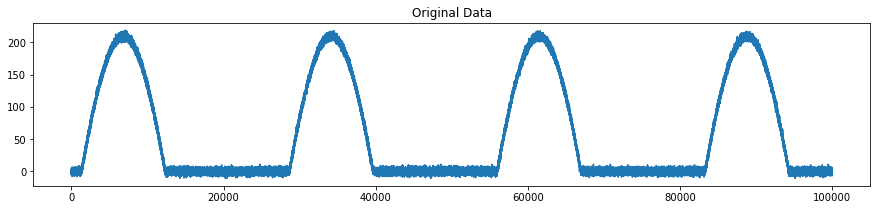

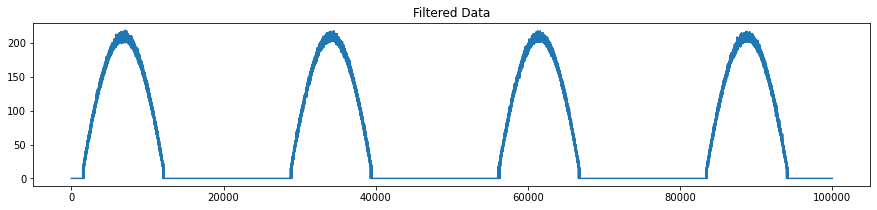

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
plt.figure(figsize = [15,3])
plt.plot(data)
plt.title("Original Data")
plt.show()

@vectorize([int16(int16)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def zero_suppression(x):
    if x < 15:
        x = 0;
    return x

data = zero_suppression(data)
plt.figure(figsize = [15,3])
plt.plot(data)
plt.title("Filtered Data")
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [6]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda

X = np.random.rand(3,3).astype('float32')
Y = np.random.rand(3,3).astype('float32')
k = np.zeros((3,3)).astype('float32')

@cuda.jit
def sigmoid_kernel(X,Y,k,a,c):
    
    row, col = cuda.grid(2)
    
    if row < k.shape[0] and col < k.shape[1]:
        dot = 0.
        for i in range(X.shape[1]):
            dot += X[i, row] * Y[i, col]
        k[row][col] = math.tanh(a * dot + c)

threadsperblock = (3, 3)
blockspergrid_x = int(math.ceil(k.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(k.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)        
        
sigmoid_kernel[blockspergrid, threadsperblock](X, Y, k, 1., 1.)        

print(X)
print(Y)
print(k)

[[0.50065374 0.15153189 0.9415627 ]
 [0.19476596 0.8014299  0.82597536]
 [0.28400618 0.07905201 0.8439633 ]]
[[0.5365528  0.1248221  0.8583311 ]
 [0.02729788 0.14595175 0.92521816]
 [0.1307731  0.93738705 0.09713234]]
[[0.8645495  0.8757287  0.9271242 ]
 [0.80530316 0.8366756  0.9544245 ]
 [0.92720836 0.9660336  0.9901521 ]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [7]:
@cuda.jit
def double_kernel_3D(io_array):
    row, col, p = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and p < io_array.shape[2]:
        io_array[row][col][p] = np.cos(io_array[row][col][p]) # do the computation

# Host code   
data = np.random.rand(256, 256, 256)

# Configure the blocks
threadsperblock = (64, 15) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

double_kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.64322759 0.03742112 0.80854865 ... 0.18020456 0.65566357 0.41017844]
  [0.77116783 0.687356   0.56121014 ... 0.64511508 0.43106177 0.28280063]
  [0.99944937 0.04192317 0.28819365 ... 0.32613642 0.8240062  0.14464874]
  ...
  [0.99997032 0.04895922 0.96768868 ... 0.66245507 0.68598788 0.08937404]
  [0.90794708 0.07218973 0.37013122 ... 0.38543943 0.80498944 0.29049035]
  [0.77271797 0.69492878 0.16450419 ... 0.37065525 0.39975731 0.03317433]]

 [[0.93207803 0.92922792 0.15051384 ... 0.16527026 0.35180381 0.1161549 ]
  [0.97212219 0.41271861 0.3126254  ... 0.91523287 0.85286219 0.55307258]
  [0.99993603 0.27775616 0.73642259 ... 0.75121512 0.93164046 0.27676781]
  ...
  [0.73089202 0.67839418 0.34587165 ... 0.21677726 0.43080023 0.34949519]
  [0.85129409 0.28152085 0.50439141 ... 0.27643002 0.34897181 0.88697812]
  [0.99376041 0.73467255 0.55915157 ... 0.78950788 0.25486185 0.35019769]]

 [[0.89295936 0.09264269 0.63718447 ... 0.48330315 0.52605087 0.13905324]
  [0.98855106 0.113747

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [8]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B"""
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(19, size = (24, 12))
B = np.random.randint(19, size = (12, 22))
C = np.zeros((24,22))
# Configure the blocks
threadsperblock = (24, 22) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print(C)

[[ 984.  864.  946. 1076.  483.  953.  520.  845. 1139.  957.  830.  689.
   893.  703.  902.  677.  733.  779.  958. 1061.  858.  648.]
 [ 833. 1022.  784. 1315.  980.  889.  740. 1028. 1369.  953.  912.  869.
   961.  704.  851.  595.  908.  664. 1152. 1025.  751.  784.]
 [ 677.  903.  736.  919.  649.  687.  440.  686. 1030.  792.  694.  829.
   870.  609.  809.  553.  968.  650.  842. 1024.  686.  821.]
 [ 957.  885. 1236. 1382.  744.  926.  592.  684. 1275. 1239. 1047.  920.
   965.  763.  884.  603. 1127.  838. 1042. 1163.  808.  764.]
 [1348. 1230. 1261. 1521. 1009. 1419.  899. 1295. 1886. 1471. 1120. 1000.
  1203.  871. 1202.  941. 1210. 1043. 1635. 1525. 1080. 1171.]
 [1079. 1188. 1247. 1477.  922. 1187.  820. 1036. 1699. 1304. 1165.  782.
   942.  710. 1268.  781. 1001.  941. 1367. 1430. 1147.  946.]
 [ 463.  569.  682.  744.  481.  640.  326.  516.  862.  778.  693.  623.
   631.  547.  670.  404.  621.  676.  799.  894.  743.  693.]
 [1005.  873.  785. 1131.  779.  873.  77